In [110]:
import warnings
warnings.filterwarnings('ignore')

In [111]:
!pip install optuna > /dev/null

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(style='seaborn')
%matplotlib inline
import tensorflow as tf

In [113]:
tf.random.set_seed(47)
np.random.seed(47)

In [114]:
import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

In [115]:
plt.rcParams['figure.figsize'] = (16,6)

In [116]:
from google.colab import files
uploaded = files.upload()

Saving NVDA.csv to NVDA.csv


In [117]:
df = pd.read_csv('NVDA.csv')
df['Date'] = pd.to_datetime(df.Date)

In [118]:
# Include only the desired columns (Open, Close, Low, High, Adj Close) and drop 'Volume'
df = df[['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close']]

# Optionally, you can rename the columns for consistency
df.columns = ['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close']

# Display the first few rows of the updated DataFrame
print(df.head())

        Date     Open    Close      Low    High  Adj Close
0 2010-01-04  0.46275  0.46225  0.45275  0.4655   0.423988
1 2010-01-05  0.46050  0.46900  0.46050  0.4740   0.430179
2 2010-01-06  0.46875  0.47200  0.46425  0.4730   0.432931
3 2010-01-07  0.46950  0.46275  0.45925  0.4715   0.424447
4 2010-01-08  0.45900  0.46375  0.45625  0.4670   0.425364


In [119]:
df.describe()

,Date,Open,Close,Low,High,Adj Close
count,2640,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000
mean,2015-04-01 01:20:43.636363776,2.029654,2.030284,1.996039,2.061769,2.000072
min,2010-01-04 00:00:00,0.218000,0.222000,0.216250,0.226250,0.203624
25%,2012-08-14 18:00:00,0.374500,0.374375,0.370188,0.379937,0.347164
50%,2015-04-01 12:00:00,0.545875,0.544875,0.538125,0.553500,0.522308
75%,2017-11-10 18:00:00,3.905625,3.911687,3.824000,3.962625,3.880558
max,2020-06-29 00:00:00,9.551000,9.526750,9.407500,9.642500,9.498450
std,NaN,2.289265,2.290133,2.249689,2.326938,2.283320


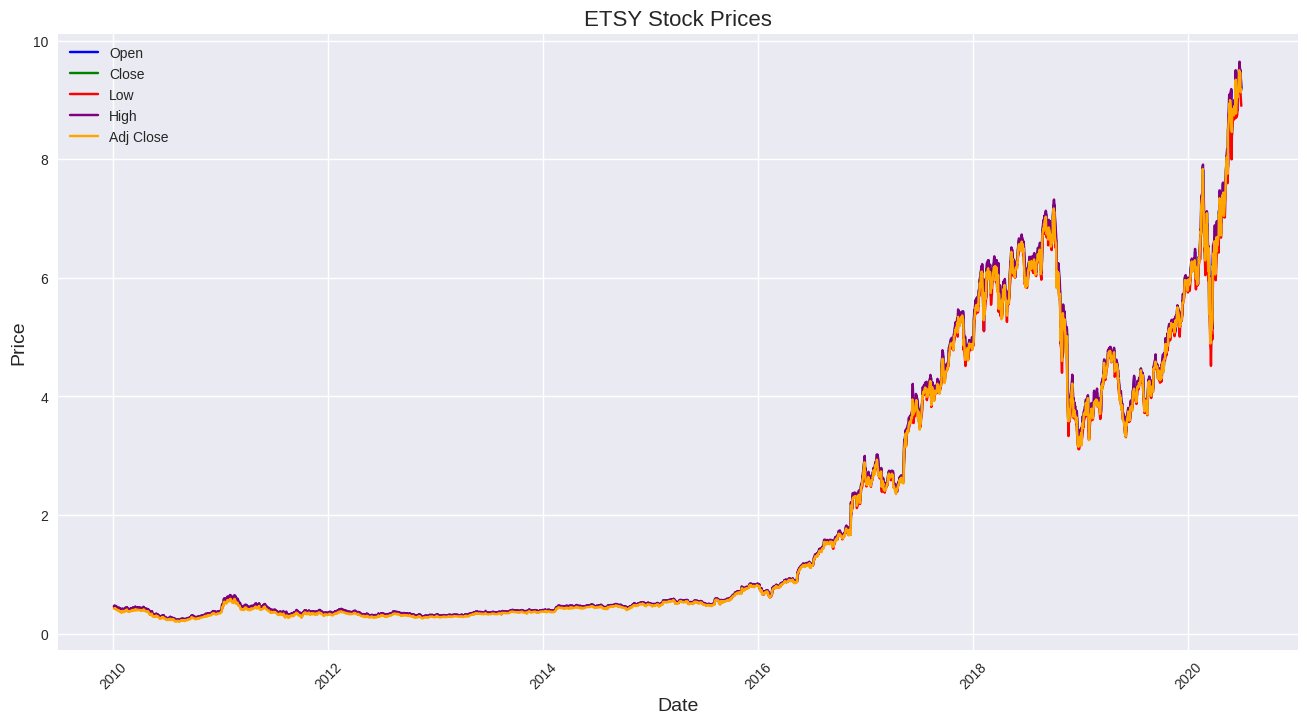

In [120]:
plt.figure(figsize=(16, 8))  # Set the figure size

plt.title('ETSY Stock Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)

# Plot all price columns
plt.plot(df['Date'], df['Open'], label='Open', color='blue')
plt.plot(df['Date'], df['Close'], label='Close', color='green')
plt.plot(df['Date'], df['Low'], label='Low', color='red')
plt.plot(df['Date'], df['High'], label='High', color='purple')
plt.plot(df['Date'], df['Adj Close'], label='Adj Close', color='orange')

plt.legend()  # Show legend
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Show grid
plt.show()

In [121]:
# Calculate the average price for each day
df['avg_price'] = df[['Open', 'Close', 'Low', 'High', 'Adj Close']].mean(axis=1)

# Calculate percentage change based on the average price
df['returns'] = df['avg_price'].pct_change() * 100

# Drop any rows with missing values generated by pct_change()
df.dropna(inplace=True)

# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)

# Display the DataFrame to verify the changes
print(df.head())

        Date     Open    Close      Low     High  Adj Close  avg_price  \
0 2010-01-05  0.46050  0.46900  0.46050  0.47400   0.430179   0.458836   
1 2010-01-06  0.46875  0.47200  0.46425  0.47300   0.432931   0.462186   
2 2010-01-07  0.46950  0.46275  0.45925  0.47150   0.424447   0.457489   
3 2010-01-08  0.45900  0.46375  0.45625  0.46700   0.425364   0.454273   
4 2010-01-11  0.46625  0.45725  0.45075  0.46825   0.419402   0.452380   

    returns  
0  1.188274  
1  0.730196  
2 -1.016214  
3 -0.703098  
4 -0.416578  


In [123]:
# Create a new DataFrame 'data' with all price features and returns
data = df[['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close', 'returns']]

# Display the first few rows of the new DataFrame
print(data.head())

        Date     Open    Close      Low     High  Adj Close   returns
0 2010-01-05  0.46050  0.46900  0.46050  0.47400   0.430179  1.188274
1 2010-01-06  0.46875  0.47200  0.46425  0.47300   0.432931  0.730196
2 2010-01-07  0.46950  0.46275  0.45925  0.47150   0.424447 -1.016214
3 2010-01-08  0.45900  0.46375  0.45625  0.46700   0.425364 -0.703098
4 2010-01-11  0.46625  0.45725  0.45075  0.46825   0.419402 -0.416578


In [124]:
# Convert the 'data' DataFrame to a NumPy array
data_array = data.values

# Display the shape of the array
print("Shape of the NumPy array:", data_array.shape)

# Optionally, display the array
print(data_array)

Shape of the NumPy array: (2639, 7)
[[Timestamp('2010-01-05 00:00:00') 0.4605 0.469 ... 0.474 0.430179
  1.1882740144616655]
 [Timestamp('2010-01-06 00:00:00') 0.46875 0.472 ... 0.473 0.432931
  0.7301958565569588]
 [Timestamp('2010-01-07 00:00:00') 0.4695 0.46275 ... 0.4715 0.424447
  -1.0162138116629027]
 ...
 [Timestamp('2020-06-25 00:00:00') 9.35575 9.49 ... 9.505 9.46181
  0.8022017288972227]
 [Timestamp('2020-06-26 00:00:00') 9.5 9.155 ... 9.5 9.127805
  -1.2490847393573978]
 [Timestamp('2020-06-29 00:00:00') 9.16975 9.2 ... 9.2045 9.172671
  -1.6395604144604503]]


In [125]:
# Drop the 'Date' column from the DataFrame
data = data.drop('Date', axis=1).values

# Display the shape of the array
print("Shape of the NumPy array:", data.shape)

# Optionally, display the array
print(data)

Shape of the NumPy array: (2639, 6)
[[ 0.4605      0.469       0.4605      0.474       0.430179    1.18827401]
 [ 0.46875     0.472       0.46425     0.473       0.432931    0.73019586]
 [ 0.4695      0.46275     0.45925     0.4715      0.424447   -1.01621381]
 ...
 [ 9.35575     9.49        9.18225     9.505       9.46181     0.80220173]
 [ 9.5         9.155       9.125       9.5         9.127805   -1.24908474]
 [ 9.16975     9.2         8.9         9.2045      9.172671   -1.63956041]]


In [126]:
from sklearn.model_selection import train_test_split

In [127]:
X_train, X_data = train_test_split(data, test_size=0.05, shuffle=False)
X_val, X_test = train_test_split(X_data, test_size=0.50, shuffle=False)

print(X_train.shape, X_val.shape, X_test.shape, sep='\n')

(2507, 6)
(66, 6)
(66, 6)


In [128]:
from sklearn.preprocessing import MinMaxScaler

In [129]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [130]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [131]:
LAG_DAYS = 1

# Generate Training set
train_gen = TimeseriesGenerator(X_train, X_train[:,0], length=LAG_DAYS, batch_size=1)

print('Train Samples: %d' % len(train_gen))

x_train, y_train = [], []
for i in range(len(train_gen)):
    x, y = train_gen[i]
    x_train.append(x[0])
    y_train.append(y[0])
x_train = np.array(x_train)
y_train = np.array(y_train)

# Generate Validation set
val_gen = TimeseriesGenerator(X_val, X_val[:,0], length=LAG_DAYS, batch_size=1)

print('Validation Samples: %d' % len(val_gen))

x_val, y_val = [], []
for i in range(len(val_gen)):
    x, y = val_gen[i]
    x_val.append(x[0])
    y_val.append(y[0])
x_val = np.array(x_val)
y_val = np.array(y_val)

# Generate Test set
test_gen = TimeseriesGenerator(X_test, X_test[:,0], length=LAG_DAYS, batch_size=1)

print('Test Samples: %d' % len(test_gen))

x_test, y_test = [], []
for i in range(len(test_gen)):
    x, y = test_gen[i]
    x_test.append(x[0])
    y_test.append(y[0])
x_test = np.array(x_test)
y_test = np.array(y_test)

Train Samples: 2506
Validation Samples: 65
Test Samples: 65


In [132]:
def prep_data_transform(data, length):
    '''Prepare data for inverse transform'''
    a = []
    a.append(data)
    [a.append(np.zeros(data.shape)) for i in range(1,length)]
    return np.c_[a].T

In [133]:
Y_train = np.round(scaler.inverse_transform(prep_data_transform(y_train, X_train.shape[1])))[:,0]
Y_val = np.round(scaler.inverse_transform(prep_data_transform(y_val, X_val.shape[1])))[:,0]
Y_test = np.round(scaler.inverse_transform(prep_data_transform(y_test, X_test.shape[1])))[:,0]

print(Y_train.shape, Y_val.shape, Y_test.shape)

(2506,) (65,) (65,)


In [134]:
x_train[1], y_train[0]

(array([[0.03574483, 0.03565317, 0.03582133, 0.03478905, 0.03291762,
         0.46041409]]),
 0.0357448325017819)

In [135]:
x_val[1], y_val[0]

(array([[0.81756949, 0.82176982, 0.82587658, 0.8154101 , 0.82636967,
         0.49785837]]),
 0.8175694939415538)

In [136]:
x_test[1], y_test[0]

(array([[0.8598717 , 0.86940245, 0.86675333, 0.89552712, 0.87466378,
         0.41623126]]),
 0.8598717034925161)

In [137]:
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

In [138]:
import optuna
import tensorflow as tf
from tensorflow.keras.layers import ConvLSTM2D, Dense, Dropout, Reshape, Flatten
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
import numpy as np

In [139]:
%%time
# Define EarlyStopping callback
early_stopping_rounds = EarlyStopping(monitor='loss', patience=50)

def run(trial):
    space = {
        'optimizer': trial.suggest_categorical('optimizer', ['Adam', 'RMSprop']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
        'epochs': trial.suggest_int('epochs', 50, 200),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64])
    }

    n_timesteps = x_train.shape[1]  # Assuming x_train is your input data
    n_features = x_train.shape[2]

    x_train_reshaped = x_train.reshape((x_train.shape[0], n_timesteps, 1, n_features, 1))
    x_val_reshaped = x_val.reshape((x_val.shape[0], n_timesteps, 1, n_features, 1))

    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                         input_shape=(n_timesteps, 1, n_features, 1),
                         return_sequences=True, padding='same'))

    model.add(Reshape((-1, 64)))
    model.add(Flatten())
    # Change the number of units in the Dense layer to match the shape of y_train or y_val
    model.add(Dense(units=1))  # Output a single value for each input
    model.add(Dropout(0.2))

    if space['optimizer'] == 'Adam':
        optimizer = optimizers.Adam(learning_rate=space['learning_rate'])
    else:
        optimizer = optimizers.RMSprop(learning_rate=space['learning_rate'])

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

    model.fit(x_train_reshaped, y_train, epochs=space['epochs'], validation_data=(x_val_reshaped, y_val),
              batch_size=space['batch_size'], callbacks=[early_stopping_rounds], verbose=0)

    yhat_val = model.predict(x_val_reshaped)

    rmse = mean_squared_error(y_val, yhat_val, squared=False) if not np.isnan(yhat_val).any() else 99999
    return rmse

# Hyperparameter Optimization with Conv LSTM
study = optuna.create_study(direction='minimize')
study.optimize(run, n_trials=10, n_jobs=-1)
print('Best trial: {}'.format(study.best_trial))

[I 2024-07-03 11:03:41,882] A new study created in memory with name: no-name-f71e78c8-1c4d-4347-8c94-dc066dc188b0


3/3 [==============================] - 1s 8ms/step


[I 2024-07-03 11:06:09,943] Trial 0 finished with value: 0.17181702871295884 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.006579527904661704, 'epochs': 105, 'batch_size': 32}. Best is trial 0 with value: 0.17181702871295884.


3/3 [==============================] - 0s 7ms/step


[I 2024-07-03 11:06:34,875] Trial 1 finished with value: 0.17154182971042398 and parameters: {'optimizer': 'Adam', 'learning_rate': 6.325588960724895e-05, 'epochs': 91, 'batch_size': 16}. Best is trial 1 with value: 0.17154182971042398.


3/3 [==============================] - 0s 7ms/step


[I 2024-07-03 11:07:44,023] Trial 3 finished with value: 0.16732500176701737 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 1.655099203160353e-05, 'epochs': 138, 'batch_size': 16}. Best is trial 3 with value: 0.16732500176701737.


3/3 [==============================] - 0s 7ms/step


[I 2024-07-03 11:07:58,209] Trial 2 finished with value: 0.1710960377313133 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.00016294413166016055, 'epochs': 51, 'batch_size': 16}. Best is trial 3 with value: 0.16732500176701737.


3/3 [==============================] - 0s 8ms/step


[I 2024-07-03 11:10:23,792] Trial 5 finished with value: 0.17256387954811228 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 7.57518481479395e-05, 'epochs': 108, 'batch_size': 16}. Best is trial 3 with value: 0.16732500176701737.


3/3 [==============================] - 0s 7ms/step


[I 2024-07-03 11:11:15,225] Trial 4 finished with value: 0.18766902213938808 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0003787005792566612, 'epochs': 122, 'batch_size': 16}. Best is trial 3 with value: 0.16732500176701737.


3/3 [==============================] - 1s 6ms/step


[I 2024-07-03 11:11:49,915] Trial 6 finished with value: 0.1609968182804887 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0003683334291948913, 'epochs': 70, 'batch_size': 32}. Best is trial 6 with value: 0.1609968182804887.


3/3 [==============================] - 1s 7ms/step


[I 2024-07-03 11:12:41,758] Trial 7 finished with value: 0.16470972430720934 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.006576625606700889, 'epochs': 55, 'batch_size': 32}. Best is trial 6 with value: 0.1609968182804887.


3/3 [==============================] - 0s 6ms/step


[I 2024-07-03 11:15:07,243] Trial 9 finished with value: 0.16982708984195544 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 2.0483313558495087e-05, 'epochs': 131, 'batch_size': 16}. Best is trial 6 with value: 0.1609968182804887.


3/3 [==============================] - 0s 4ms/step


[I 2024-07-03 11:15:32,355] Trial 8 finished with value: 0.1684186656542211 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.00019825720021927814, 'epochs': 137, 'batch_size': 16}. Best is trial 6 with value: 0.1609968182804887.


Best trial: FrozenTrial(number=6, state=TrialState.COMPLETE, values=[0.1609968182804887], datetime_start=datetime.datetime(2024, 7, 3, 11, 10, 23, 796891), datetime_complete=datetime.datetime(2024, 7, 3, 11, 11, 49, 915534), params={'optimizer': 'RMSprop', 'learning_rate': 0.0003683334291948913, 'epochs': 70, 'batch_size': 32}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'optimizer': CategoricalDistribution(choices=('Adam', 'RMSprop')), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'epochs': IntDistribution(high=200, log=False, low=50, step=1), 'batch_size': CategoricalDistribution(choices=(16, 32, 64))}, trial_id=6, value=None)
CPU times: user 17min 7s, sys: 1min 16s, total: 18min 24s
Wall time: 11min 50s


In [140]:
best_params = study.best_params
best_params

{'optimizer': 'RMSprop',
 'learning_rate': 0.0003683334291948913,
 'epochs': 70,
 'batch_size': 32}

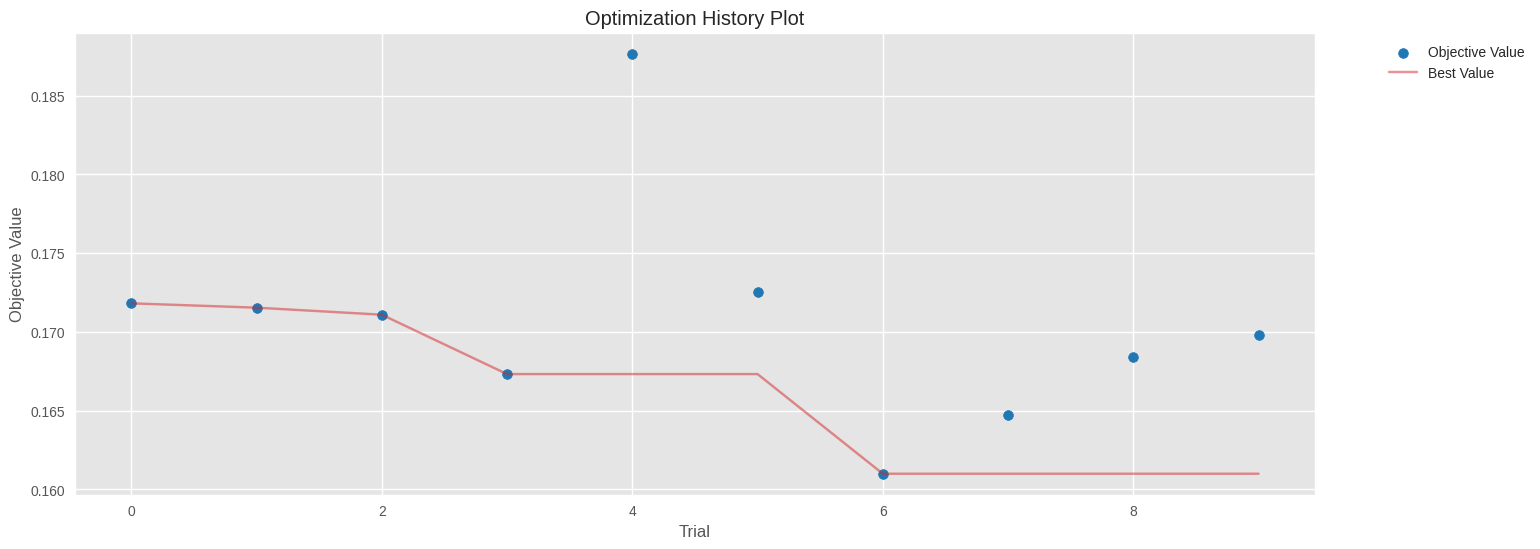

In [143]:
plot_optimization_history(study);

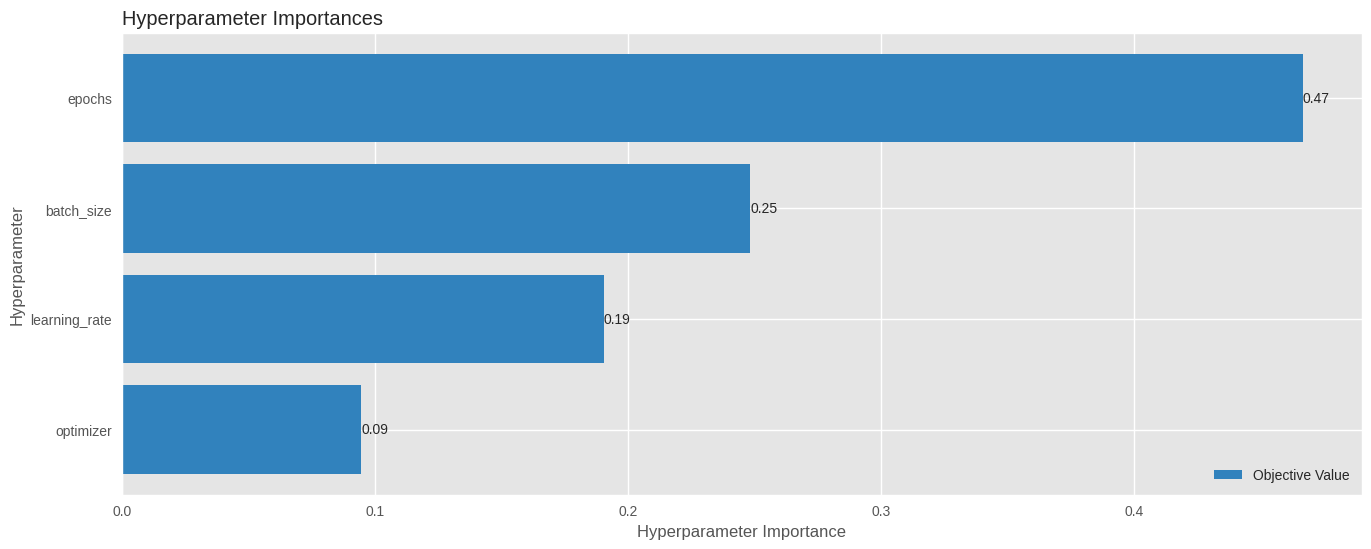

In [144]:
plot_param_importances(study);

In [145]:
optuna.visualization.plot_slice(study, params=['epochs', 'learning_rate'])

In [146]:
# Define the LSTM model using the best hyperparameters
model = Sequential()
# Check if 'units' is in best_params, if not, provide a default value
units = best_params.get("units", 64)  # Default to 64 units if not found
model.add(LSTM(units=units, input_shape=(x_train.shape[1], x_train.shape[2])))

# Check if 'dropout_rate' exists in best_params before using it
if 'dropout_rate' in best_params:
    model.add(Dropout(rate=best_params["dropout_rate"]))

model.add(Dense(units=1))

# Compile the model with the best optimizer and learning rate
if best_params['optimizer'] == 'Adam':
    optimizer = optimizers.Adam(learning_rate=best_params['learning_rate'])
else:
    optimizer = optimizers.RMSprop(learning_rate=best_params['learning_rate'])

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                18176     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18241 (71.25 KB)
Trainable params: 18241 (71.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


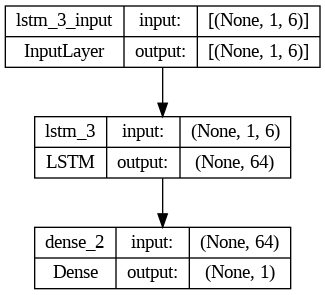

In [148]:
plot_model(model, show_shapes=True)

In [149]:
%%time
history = model.fit(x_train, y_train, epochs=best_params['epochs'], validation_data=(x_val, y_val), batch_size=best_params['batch_size'], verbose=0)

CPU times: user 27.4 s, sys: 1.91 s, total: 29.3 s
Wall time: 23.7 s


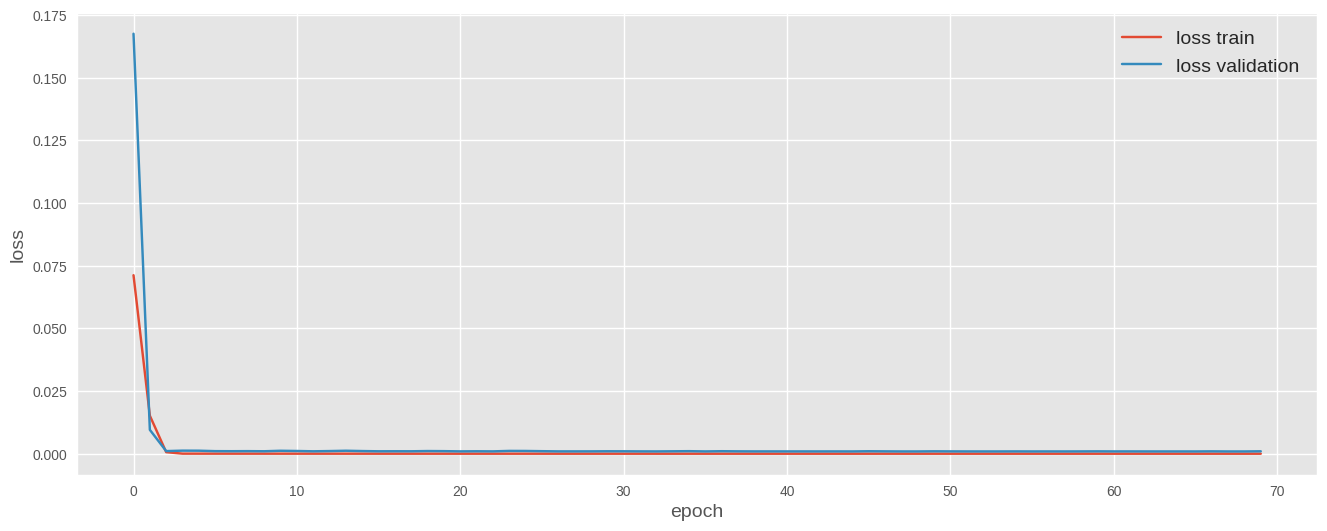

In [150]:
plt.plot(history.history['loss'], label='loss train')
plt.plot(history.history['val_loss'], label='loss validation')
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [151]:
model.evaluate(x_test, y_test, batch_size=best_params['batch_size'])

3/3 [==============================] - 0s 5ms/step - loss: 6.2022e-04 - accuracy: 0.0000e+00


[0.0006202158401720226, 0.0]

In [152]:
yhat_train = np.squeeze(model.predict(x_train))
yhat_test = np.squeeze(model.predict(x_test))

3/3 [==============================] - 0s 3ms/step


In [153]:
yhat_train = scaler.inverse_transform(prep_data_transform(yhat_train, X_train.shape[1]))[:,0]
yhat_test = scaler.inverse_transform(prep_data_transform(yhat_test, X_test.shape[1]))[:,0]
print(yhat_train.shape, yhat_test.shape)

(2506,) (65,)


In [154]:
print('Train Predicted: ', yhat_train[:5])
print('Train Actual: ', Y_train[:5])

print('Test Predicted: ', yhat_test[:5])
print('Test Actual: ', Y_test[:5])

Train Predicted:  [0.48794009 0.48969141 0.47872082 0.47702338 0.47580891]
Train Actual:  [0. 0. 0. 0. 0.]
Test Predicted:  [6.47066534 6.36779784 6.61250057 6.67917002 6.19433259]
Test Actual:  [6. 6. 7. 6. 6.]


In [155]:
# calculate root mean squared error
trainScore = mean_squared_error(Y_train, yhat_train, squared=False)
print('Train Score: %.2f RMSE' % (trainScore))

testScore = mean_squared_error(Y_test, yhat_test, squared=False)
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.37 RMSE
Test Score: 0.33 RMSE


In [156]:
date_train = df['Date'][LAG_DAYS:len(Y_train) + LAG_DAYS]
date_test = df['Date'][-len(Y_test):]

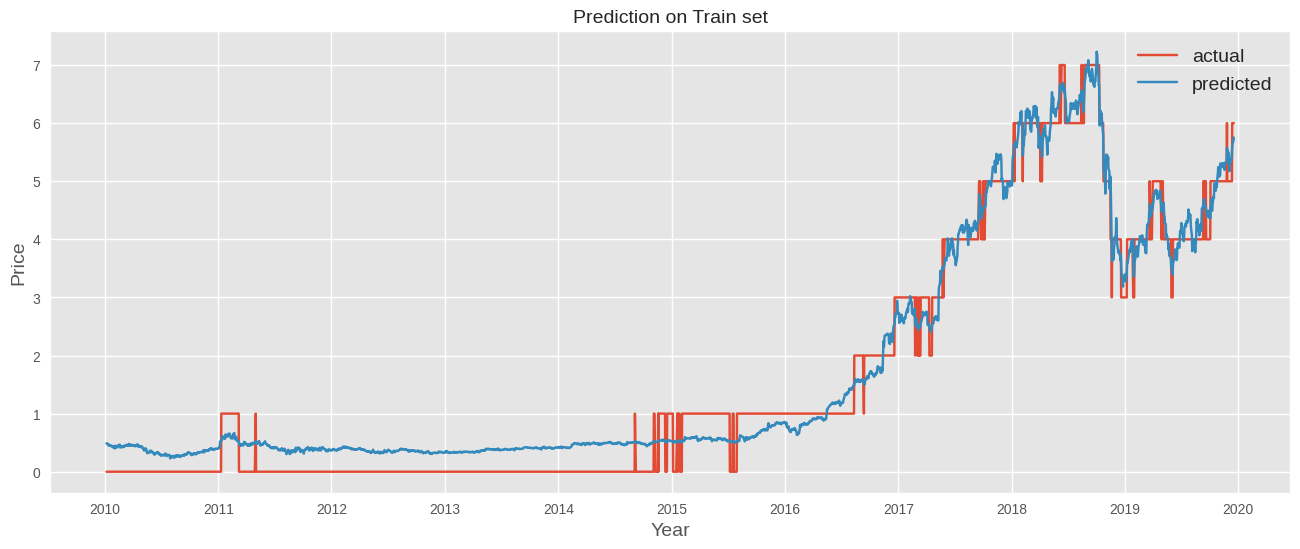

In [157]:
plt.title('Prediction on Train set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_train, Y_train, label='actual')
plt.plot(date_train, yhat_train, label='predicted')
plt.legend(fontsize=14)
plt.show()

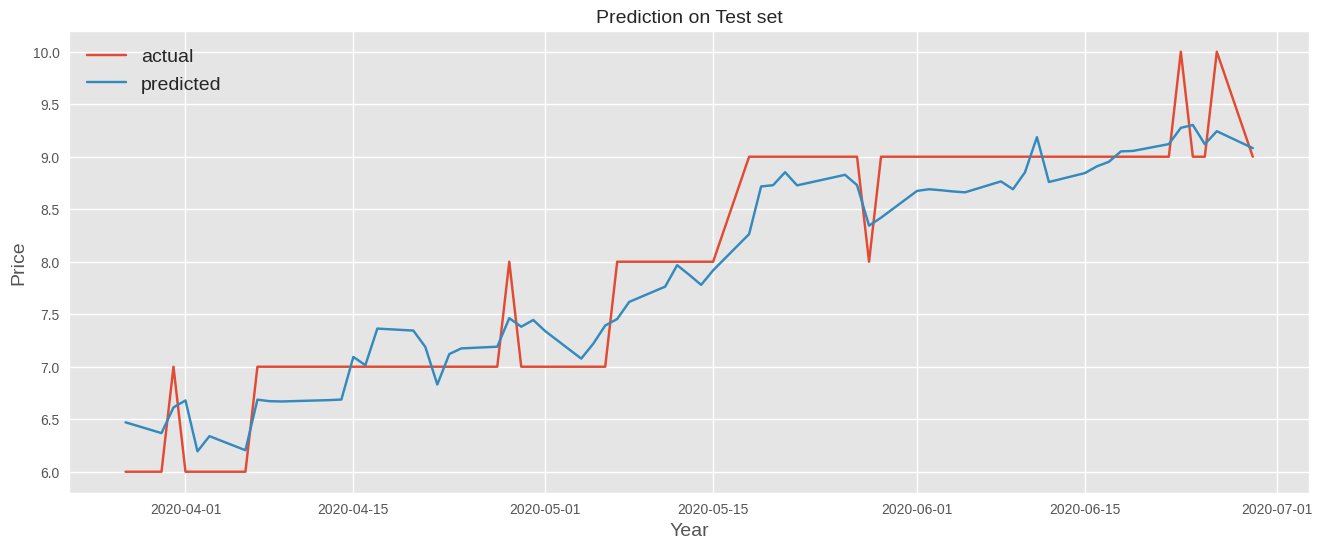

In [158]:
plt.title('Prediction on Test set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_test, Y_test, label='actual')
plt.plot(date_test, yhat_test, label='predicted')
plt.legend(fontsize=14)
plt.show()

In [159]:
yhat_test

array([6.47066534, 6.36779784, 6.61250057, 6.67917002, 6.19433259,
       6.33856912, 6.20473349, 6.68644333, 6.67192012, 6.6690894 ,
       6.68205425, 6.68737659, 7.09310195, 7.01483744, 7.3633518 ,
       7.34419658, 7.18888054, 6.83049504, 7.12064144, 7.17450869,
       7.19041339, 7.46234243, 7.38123842, 7.44503617, 7.33893488,
       7.07741134, 7.21838522, 7.39260059, 7.4543905 , 7.61736704,
       7.76273878, 7.96722359, 7.87575171, 7.77950817, 7.91819323,
       8.26302306, 8.71675229, 8.72899001, 8.85249624, 8.7271904 ,
       8.82766287, 8.72967658, 8.34396233, 8.41929871, 8.67429237,
       8.69046132, 8.68076915, 8.66929826, 8.66075928, 8.76496395,
       8.6902347 , 8.85047   , 9.1864322 , 8.75924314, 8.84397566,
       8.90835628, 8.9514066 , 9.05074762, 9.05505181, 9.12022939,
       9.27509093, 9.30199905, 9.11942491, 9.24295037, 9.08177596])

In [160]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Y_test' contains actual values and 'yhat_test' contains predicted values

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_test, yhat_test)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test, yhat_test)

# Calculate R-squared (R2) score
r2 = r2_score(Y_test, yhat_test)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((Y_test - yhat_test) / Y_test)) * 100

# Display the Mean Absolute Percentage Error (MAPE)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 0.10801565553828826
Root Mean Squared Error (RMSE): 0.32865735278293756
Mean Absolute Error (MAE): 0.2808257411195683
R-squared (R2) Score: 0.9121697181198484
Mean Absolute Percentage Error (MAPE): 3.61%


In [164]:
# Assuming 'Y_train' contains actual values and 'yhat_train' contains predicted values

# Calculate Mean Absolute Percentage Error (MAPE)
mape_train = np.mean(np.abs((Y_train - yhat_train) / Y_train)) * 100

# Display the Mean Absolute Percentage Error (MAPE) for the training set
print(f'Mean Absolute Percentage Error (MAPE) on Training set: {mape_train:.2f}%')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Y_train' contains the actual values and 'yhat_train' contains the predicted values for the training set

# Calculate Mean Squared Error (MSE) on the training set
mse_train = mean_squared_error(Y_train, yhat_train)

# Calculate Root Mean Squared Error (RMSE) on the training set
rmse_train = np.sqrt(mse_train)

# Calculate Mean Absolute Error (MAE) on the training set
mae_train = mean_absolute_error(Y_train, yhat_train)

# Calculate R-squared (R2) score on the training set
r2_train = r2_score(Y_train, yhat_train)

# Display the accuracy metrics for the training set
print(f'Mean Squared Error (MSE) on Training set: {mse_train:.2f}')
print(f'Root Mean Squared Error (RMSE) on Training set: {rmse_train:.2f}')
print(f'Mean Absolute Error (MAE) on Training set: {mae_train:.2f}')
print(f'R-squared (R2) Score on Training set: {r2_train:.2f}')

Mean Absolute Percentage Error (MAPE) on Training set: inf%
Mean Squared Error (MSE) on Training set: 0.13
Root Mean Squared Error (RMSE) on Training set: 0.37
Mean Absolute Error (MAE) on Training set: 0.34
R-squared (R2) Score on Training set: 0.97


In [162]:
import numpy as np

def calculate_forecast_accuracy(yhat_test, Y_test):
    # Calculate the forecast accuracy using the given formula
    accuracy = 1 - np.abs(yhat_test - Y_test) / Y_test
    return accuracy

# Compute forecast accuracy for the test set
forecast_accuracy = calculate_forecast_accuracy(yhat_test, Y_test)

# Calculate the mean accuracy across all data points
mean_accuracy = np.mean(forecast_accuracy)

print(f'Mean Forecast Accuracy on Test Set: {mean_accuracy:.2f}')

Mean Forecast Accuracy on Test Set: 0.96


In [165]:
def calculate_forecast_accuracy(yhat_train, Y_train):
    # Calculate the forecast accuracy using the given formula
    accuracy = 1 - np.abs(yhat_train - Y_train) / Y_train
    return accuracy

# Compute forecast accuracy for the training set
forecast_accuracy_train = calculate_forecast_accuracy(yhat_train, Y_train)

# Calculate the mean accuracy across all data points
mean_accuracy_train = np.mean(forecast_accuracy_train)

print(f'Mean Forecast Accuracy on Training Set: {mean_accuracy_train:.2f}')

Mean Forecast Accuracy on Training Set: -inf
